# Cifar10 Drift Detection

In this example we will deploy an image classification model along with a drift detector trained on the same dataset. For in depth details on creating a drift detection model for your own dataset see the [alibi-detect project](https://github.com/SeldonIO/alibi-detect) and associated [documentation](https://docs.seldon.ai/alibi-detect). You can find details for this [CIFAR10 example in their documentation](https://docs.seldon.ai/alibi-detect/cd/examples/cd_ks_cifar10) as well.


Prequisites:

 * [Knative eventing installed](https://knative.dev/docs/install/)
     * Ensure the istio-ingressgateway is exposed as a loadbalancer (no auth in this demo)
 * [Seldon Core installed](https://docs.seldon.ai/seldon-core-1/getting-started/installation/installation) 
    * Ensure you install for istio, e.g. for the helm chart `--set istio.enabled=true`
 
 Tested on GKE and Kind with Knative 1.10.1 and Istio 1.16.2

In [ ]:
!pip install -r requirements_notebook.txt

Ensure gateway installed

In [ ]:
!kubectl apply -f ../../../notebooks/resources/seldon-gateway.yaml

## Setup Resources

In [28]:
!kubectl create namespace cifar10drift

namespace/cifar10drift created


In [29]:
%%writefile broker.yaml
apiVersion: eventing.knative.dev/v1
kind: Broker
metadata:
 name: default
 namespace: cifar10drift

Overwriting broker.yaml


In [30]:
!kubectl create -f broker.yaml

broker.eventing.knative.dev/default created


In [31]:
%%writefile event-display.yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: hello-display
  namespace: cifar10drift
spec:
  replicas: 1
  selector:
    matchLabels: &labels
      app: hello-display
  template:
    metadata:
      labels: *labels
    spec:
      containers:
        - name: event-display
          image: gcr.io/knative-releases/knative.dev/eventing/cmd/event_display

---

kind: Service
apiVersion: v1
metadata:
  name: hello-display
  namespace: cifar10drift
spec:
  selector:
    app: hello-display
  ports:
  - protocol: TCP
    port: 80
    targetPort: 8080

Overwriting event-display.yaml


In [32]:
!kubectl apply -f event-display.yaml

deployment.apps/hello-display created
service/hello-display created


Create the SeldonDeployment image classification model for Cifar10. We add in a `logger` for requests - the default destination is the namespace Knative Broker.

In [33]:
%%writefile cifar10.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: tfserving-cifar10
  namespace: cifar10drift
spec:
  protocol: tensorflow
  transport: rest
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - args: 
          - --port=8500
          - --rest_api_port=8501
          - --model_name=resnet32
          - --model_base_path=gs://seldon-models/tfserving/cifar10/resnet32
          image: tensorflow/serving
          name: resnet32
          ports:
          - containerPort: 8501
            name: http
            protocol: TCP
    graph:
      name: resnet32
      type: MODEL
      endpoint:
        service_port: 8501
      logger:
        mode: all
        url: http://broker-ingress.knative-eventing.svc.cluster.local/cifar10drift/default
    name: model
    replicas: 1


Overwriting cifar10.yaml


In [34]:
!kubectl apply -f cifar10.yaml

seldondeployment.machinelearning.seldon.io/tfserving-cifar10 created


Create the pretrained Drift Detector. We forward replies to the message-dumper we started. Notice the `drift_batch_size`. The drift detector will wait until `drify_batch_size` number of requests are received before making a drift prediction.

Here we configure `seldonio/alibi-detect-server` to use rclone for downloading the artifact. 
If `RCLONE_ENABLED=true` environmental variable is set or any of the environmental variables contain `RCLONE_CONFIG` in their name then rclone
will be used to download the artifacts. If `RCLONE_ENABLED=false` or no `RCLONE_CONFIG` variables are present then kfserving storage.py logic will be used to download the artifacts.

In [35]:
%%writefile cifar10cd.yaml

apiVersion: v1
kind: Secret
metadata:
  name: seldon-rclone-secret
  namespace: cifar10drift    
type: Opaque
stringData:
  RCLONE_CONFIG_GS_TYPE: google cloud storage
  RCLONE_CONFIG_GS_ANONYMOUS: "true"

---            


apiVersion: serving.knative.dev/v1
kind: Service
metadata:
  name: drift-detector
  namespace: cifar10drift
spec:
  template:
    metadata:
      annotations:
        autoscaling.knative.dev/minScale: "1"
    spec:
      containers:
      - image: seldonio/alibi-detect-server:1.19.0-dev
        imagePullPolicy: IfNotPresent
        args:
        - --model_name
        - cifar10cd
        - --http_port
        - '8080'
        - --protocol
        - tensorflow.http
        - --storage_uri
        - gs://seldon-models/alibi-detect/cd/ks/cifar10-0_6_2
        - --reply_url
        - http://hello-display.cifar10drift
        - --event_type
        - io.seldon.serving.inference.drift
        - --event_source
        - io.seldon.serving.cifar10cd
        - DriftDetector
        - --drift_batch_size
        - '5000'
        envFrom:
        - secretRef:
            name: seldon-rclone-secret        

Overwriting cifar10cd.yaml


In [36]:
!kubectl apply -f cifar10cd.yaml

secret/seldon-rclone-secret created
service.serving.knative.dev/drift-detector created


Create a Knative trigger to forward logging events to our Drift Detector.

In [37]:
%%writefile trigger.yaml
apiVersion: eventing.knative.dev/v1
kind: Trigger
metadata:
  name: drift-trigger
  namespace: cifar10drift
spec:
  broker: default
  filter:
    attributes:
      type: io.seldon.serving.inference.request
  subscriber:
    ref:
      apiVersion: serving.knative.dev/v1
      kind: Service
      name: drift-detector
      namespace: cifar10drift


Overwriting trigger.yaml


In [38]:
!kubectl apply -f trigger.yaml

trigger.eventing.knative.dev/drift-trigger created


Get the IP address of the Istio Ingress Gateway. This assumes you have installed istio with a LoadBalancer.

In [ ]:
CLUSTER_IPS = !(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.status.loadBalancer.ingress[0].ip}')
CLUSTER_IP = CLUSTER_IPS[0]
print(CLUSTER_IP)

If you are using Kind or Minikube you will need to port-forward to the istio ingressgateway and uncomment the following

In [39]:
CLUSTER_IP = "localhost:8080"

In [40]:
SERVICE_HOSTNAMES = !(kubectl get ksvc -n cifar10drift drift-detector -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_CD = SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_CD)

drift-detector.cifar10drift.svc.cluster.local


In [41]:
import json

import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf

tf.keras.backend.clear_session()

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis("off")
    plt.show()


def predict(X):
    formData = {"instances": X.tolist()}
    headers = {}
    res = requests.post(
        "http://"
        + CLUSTER_IP
        + "/seldon/cifar10drift/tfserving-cifar10/v1/models/resnet32/:predict",
        json=formData,
        headers=headers,
    )
    if res.status_code == 200:
        j = res.json()
        if len(j["predictions"]) == 1:
            return classes[np.array(j["predictions"])[0].argmax()]
    else:
        print("Failed with ", res.status_code)
        return []


def drift(X):
    formData = {"instances": X.tolist()}
    headers = {}
    headers = {
        "ce-namespace": "default",
        "ce-modelid": "cifar10drift",
        "ce-type": "io.seldon.serving.inference.request",
        "ce-id": "1234",
        "ce-source": "localhost",
        "ce-specversion": "1.0",
    }
    headers["Host"] = SERVICE_HOSTNAME_CD
    res = requests.post("http://" + CLUSTER_IP + "/", json=formData, headers=headers)
    if res.status_code == 200:
        od = res.json()
        return od
    else:
        print("Failed with ", res.status_code)
        return []

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Normal Prediction

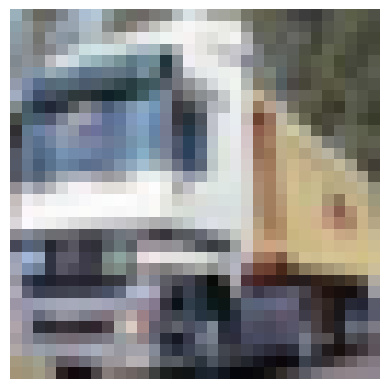

'truck'

In [42]:
idx = 1
X = X_train[idx : idx + 1]
show(X)
predict(X)

## Test Drift

We need to accumulate a large enough batch size so no drift will be tested as yet.

In [43]:
!kubectl logs -n cifar10drift $(kubectl get pod -n cifar10drift -l app=hello-display -o jsonpath='{.items[0].metadata.name}')

2025/12/12 14:40:22 failed to parse observability config from env, falling back to default config
2025/12/12 14:40:22 failed to correctly initialize otel resource, resouce may be missing some attributes: the environment variable "SYSTEM_NAMESPACE" is not set, not adding "k8s.namespace.name" to otel attributes


We will now send 5000 requests to the model in batches. The drift detector will run at the end of this as we set the `drift_batch_size` to 5000 in our yaml above.

In [44]:
from tqdm import tqdm

for i in tqdm(range(0, 5000, 100)):
    X = X_train[i : i + 100]
    predict(X)

100%|██████████| 50/50 [00:29<00:00,  1.67it/s]


Let's check the message dumper and extract the first drift result.

In [45]:
!kubectl logs -n cifar10drift $(kubectl get pod -n cifar10drift -l app=hello-display -o jsonpath='{.items[0].metadata.name}')

2025/12/12 14:40:22 failed to parse observability config from env, falling back to default config
2025/12/12 14:40:22 failed to correctly initialize otel resource, resouce may be missing some attributes: the environment variable "SYSTEM_NAMESPACE" is not set, not adding "k8s.namespace.name" to otel attributes
☁️  cloudevents.Event
Context Attributes,
  specversion: 1.0
  type: io.seldon.serving.inference.drift
  source: io.seldon.serving.cifar10cd
  id: 3ce19429-8ea8-4c3c-bd2b-f6dcf7095024
Extensions,
  endpoint: model
  inferenceservicename: tfserving-cifar10
  knativearrivaltime: 2025-12-12T14:44:49.320841479Z
  modelid: resnet32
  namespace: cifar10drift
  protocol: tensorflow
  requestid: d93280e9-d589-450f-872d-f3f94a0cd39c
  traceparent: 00-84ed71c88837c6aac5041d57cba35b39-7b140fa51bb1f456-00
Data,
  {"data": {"is_drift": 0, "distance": [0.02034001238644123, 0.015247910283505917, 0.01797136664390564, 0.020757608115673065, 0.015546650625765324, 0.020235512405633926, 0.017444431781

Now, let's create some CIFAR10 examples with motion blur.

In [46]:
from alibi_detect.datasets import corruption_types_cifar10c, fetch_cifar10c

corruption = ["motion_blur"]
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype("float32") / 255

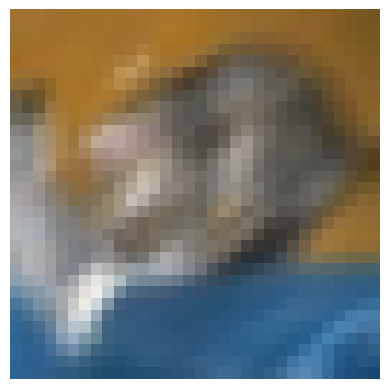

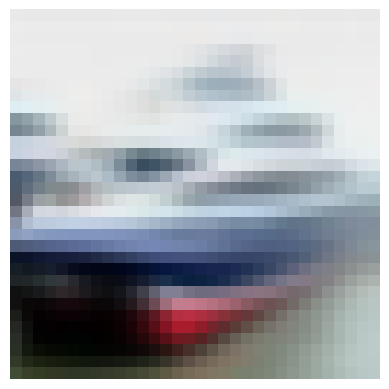

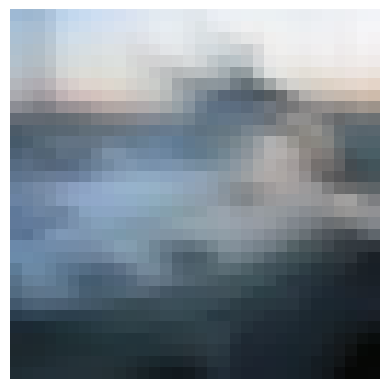

In [47]:
show(X_corr[0])
show(X_corr[1])
show(X_corr[2])

Send these examples to the predictor.

In [48]:
for i in tqdm(range(0, 5000, 100)):
    X = X_corr[i : i + 100]
    predict(X)

100%|██████████| 50/50 [00:29<00:00,  1.72it/s]


Now when we check the message dump we should find a new drift response.

In [49]:
!kubectl logs -n cifar10drift $(kubectl get pod -n cifar10drift -l app=hello-display -o jsonpath='{.items[0].metadata.name}')

2025/12/12 14:40:22 failed to parse observability config from env, falling back to default config
2025/12/12 14:40:22 failed to correctly initialize otel resource, resouce may be missing some attributes: the environment variable "SYSTEM_NAMESPACE" is not set, not adding "k8s.namespace.name" to otel attributes
☁️  cloudevents.Event
Context Attributes,
  specversion: 1.0
  type: io.seldon.serving.inference.drift
  source: io.seldon.serving.cifar10cd
  id: 3ce19429-8ea8-4c3c-bd2b-f6dcf7095024
Extensions,
  endpoint: model
  inferenceservicename: tfserving-cifar10
  knativearrivaltime: 2025-12-12T14:44:49.320841479Z
  modelid: resnet32
  namespace: cifar10drift
  protocol: tensorflow
  requestid: d93280e9-d589-450f-872d-f3f94a0cd39c
  traceparent: 00-84ed71c88837c6aac5041d57cba35b39-7b140fa51bb1f456-00
Data,
  {"data": {"is_drift": 0, "distance": [0.02034001238644123, 0.015247910283505917, 0.01797136664390564, 0.020757608115673065, 0.015546650625765324, 0.020235512405633926, 0.017444431781

## Tear Down

In [50]:
!kubectl delete ns cifar10drift

namespace "cifar10drift" deleted
